In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import mahalanobis
from scipy.stats import norm, wilcoxon
import pulp
import matplotlib.pyplot as plt

# Simulate longitudinal data for 400 patients
np.random.seed(42)
n_patients = 400
time_points = np.arange(0, 25, 3)  # 0-24 months in 3-month intervals

# Generate patient data
patients = []
for pid in range(n_patients):
    base_pain = np.random.randint(0, 10)
    base_urgency = np.random.randint(0, 10)
    base_freq = np.random.randint(0, 10)
    
    # Simulate time-varying symptoms with autoregressive process
    pain = [base_pain + np.random.randint(-1, 2)]
    urgency = [base_urgency + np.random.randint(-1, 2)]
    freq = [base_freq + np.random.randint(-1, 2)]
    for t in range(1, len(time_points)):
        pain.append(pain[-1] + np.random.randint(-1, 2))
        urgency.append(urgency[-1] + np.random.randint(-1, 2))
        freq.append(freq[-1] + np.random.randint(-1, 2))
    
    # Clip to 0-9 scale
    pain = np.clip(pain, 0, 9)
    urgency = np.clip(urgency, 0, 9)
    freq = np.clip(freq, 0, 9)
    
    # Treatment assignment (hazard increases with recent symptom worsening)
    treat_prob = 0.1 + 0.05*(np.mean(pain[-2:]) > 5)  # Simplified model
    treated = np.random.binomial(1, treat_prob)
    treat_time = np.random.choice(time_points[1:-1]) if treated else np.inf
    
    patients.append({
        'id': pid,
        'treated': treated,
        'treat_time': treat_time,
        'base_pain': base_pain,
        'base_urgency': base_urgency,
        'base_freq': base_freq,
        'time_pain': pain,
        'time_urgency': urgency,
        'time_freq': freq,
    })

df = pd.DataFrame(patients)

In [2]:
df.head()

,id,treated,treat_time,base_pain,base_urgency,base_freq,time_pain,time_urgency,time_freq
0,0,0,inf,6,3,7,"[5, 5, 6, 7, 7, 7, 7, 6, 7]","[2, 3, 4, 4, 4, 3, 3, 2, 3]","[8, 9, 8, 7, 7, 6, 5, 6, 6]"
1,1,0,inf,2,6,3,"[1, 2, 1, 0, 0, 0, 0, 1, 1]","[7, 8, 9, 9, 8, 8, 7, 7, 7]","[2, 1, 1, 1, 1, 2, 3, 2, 2]"
2,2,0,inf,9,3,5,"[8, 8, 8, 9, 8, 7, 6, 5, 6]","[4, 4, 4, 4, 4, 4, 4, 3, 2]","[5, 5, 6, 7, 6, 7, 6, 5, 4]"
3,3,0,inf,8,7,0,"[9, 8, 7, 7, 6, 6, 7, 8, 9]","[8, 9, 9, 9, 9, 9, 9, 9, 9]","[1, 2, 1, 1, 0, 1, 0, 1, 2]"
4,4,0,inf,2,0,4,"[2, 2, 1, 1, 2, 1, 0, 0, 0]","[1, 2, 3, 3, 4, 3, 4, 5, 4]","[5, 6, 7, 6, 7, 7, 8, 9, 9]"


In [3]:
df['treat_time'].value_counts()

treat_time
inf     347
3.0      11
6.0      10
21.0      9
18.0      7
12.0      6
15.0      5
9.0       5
Name: count, dtype: int64

In [4]:
# Add this before matching:
# df['time_pain_latest'] = df['time_pain'].apply(lambda x: x[-1] if isinstance(x, list) else x)
# df['time_urgency_latest'] = df['time_urgency'].apply(lambda x: x[-1] if isinstance(x, list) else x)
# df['time_freq_latest'] = df['time_freq'].apply(lambda x: x[-1] if isinstance(x, list) else x)

In [5]:
df.head()

,id,treated,treat_time,base_pain,base_urgency,base_freq,time_pain,time_urgency,time_freq
0,0,0,inf,6,3,7,"[5, 5, 6, 7, 7, 7, 7, 6, 7]","[2, 3, 4, 4, 4, 3, 3, 2, 3]","[8, 9, 8, 7, 7, 6, 5, 6, 6]"
1,1,0,inf,2,6,3,"[1, 2, 1, 0, 0, 0, 0, 1, 1]","[7, 8, 9, 9, 8, 8, 7, 7, 7]","[2, 1, 1, 1, 1, 2, 3, 2, 2]"
2,2,0,inf,9,3,5,"[8, 8, 8, 9, 8, 7, 6, 5, 6]","[4, 4, 4, 4, 4, 4, 4, 3, 2]","[5, 5, 6, 7, 6, 7, 6, 5, 4]"
3,3,0,inf,8,7,0,"[9, 8, 7, 7, 6, 6, 7, 8, 9]","[8, 9, 9, 9, 9, 9, 9, 9, 9]","[1, 2, 1, 1, 0, 1, 0, 1, 2]"
4,4,0,inf,2,0,4,"[2, 2, 1, 1, 2, 1, 0, 0, 0]","[1, 2, 3, 3, 4, 3, 4, 5, 4]","[5, 6, 7, 6, 7, 7, 8, 9, 9]"


In [6]:
df.dtypes

id                int64
treated           int64
treat_time      float64
base_pain         int64
base_urgency      int64
base_freq         int64
time_pain        object
time_urgency     object
time_freq        object
dtype: object

In [7]:
def balanced_risk_set_matching(df):
    # Step 1: Extract the latest pre-treatment measurement for time-varying covariates
    df['time_pain_latest'] = df['time_pain'].apply(lambda x: x[-1] if isinstance(x, list) else x)
    df['time_urgency_latest'] = df['time_urgency'].apply(lambda x: x[-1] if isinstance(x, list) else x)
    df['time_freq_latest'] = df['time_freq'].apply(lambda x: x[-1] if isinstance(x, list) else x)
    
    # Step 2: Define covariates to balance
    covariates = ['base_pain', 'base_urgency', 'base_freq', 
                  'time_pain_latest', 'time_urgency_latest', 'time_freq_latest']
    
    # Step 3: Calculate quantile boundaries for balancing
    quantiles = {}
    for col in covariates:
        # Flatten any lists or arrays in the column
        flattened_col = df[col].apply(lambda x: x if np.isscalar(x) else x[-1])  # Use last value if it's a list
        quantiles[col] = np.quantile(flattened_col, [0.33, 0.67])
    
    # Step 4: Create binary indicators for quantile groups
    for col in covariates:
        # Ensure column contains numeric scalars
        flattened_col = df[col].apply(lambda x: x if np.isscalar(x) else x[-1])
        for i, q in enumerate(quantiles[col]):
            # Use the flattened version for comparison
            df[f'{col}_q{i+1}'] = (flattened_col > q).astype(int)

    
    # Step 5: Initialize optimization problem
    prob = pulp.LpProblem("BalancedMatching", pulp.LpMinimize)
    
    # Step 6: Create decision variables
    treated = df[df['treated'] == 1].sort_values('treat_time')
    controls = df[df['treated'] == 0].copy()
    edges = []
    for _, t_row in treated.iterrows():
        t_time = t_row['treat_time']
        # Eligible controls: Not treated by t_time
        eligible = controls[controls['treat_time'] > t_time]
        for _, c_row in eligible.iterrows():
            edges.append((t_row['id'], c_row['id']))
    
    x = pulp.LpVariable.dicts("pair", edges, cat='Binary')
    
    # Step 7: Objective: Minimize Mahalanobis distance
    # Ensure all covariates contain numeric data
    processed_covariates = pd.DataFrame({
        col: df[col].apply(lambda x: x if np.isscalar(x) else x[-1])  # Flatten if needed
        for col in covariates
    })

    # Calculate covariance matrix
    cov_matrix = np.cov(processed_covariates.T)
    inv_cov = np.linalg.pinv(cov_matrix)
    distances = {}
    for (t, c) in edges:
        t_vec = df.loc[df['id'] == t, covariates].values.ravel()
        c_vec = df.loc[df['id'] == c, covariates].values.ravel()
        distances[(t, c)] = mahalanobis(t_vec, c_vec, inv_cov)
    
    prob += pulp.lpSum([distances[e] * x[e] for e in edges])
    
    # Step 8: Balance constraints
    balance_vars = [col for col in df.columns if '_q' in col]
    for col in balance_vars:
        treated_total = df[df['treated'] == 1][col].sum()
        control_expr = pulp.lpSum([df.loc[df['id'] == c, col].values[0] * x[(t, c)] 
                                 for (t, c) in edges])
        prob += control_expr == treated_total
    
    # Step 9: Solve the optimization problem
    prob.solve(pulp.PULP_CBC_CMD(msg=False))
    
    # Step 10: Extract matched pairs
    matched_pairs = []
    for (t, c) in edges:
        if x[(t, c)].value() > 0.5:
            matched_pairs.append((t, c))
    
    return matched_pairs

In [8]:
matched_pairs = balanced_risk_set_matching(df)

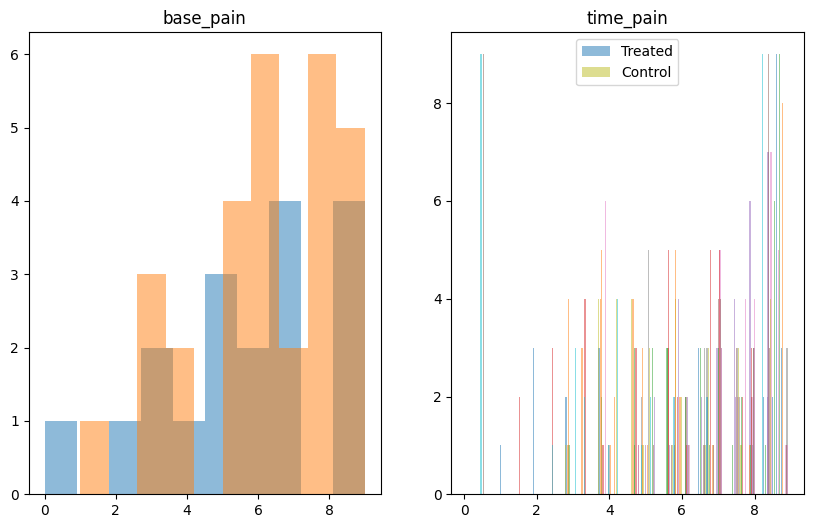

In [9]:
def assess_balance(df, matched_pairs):
    treated_ids = [p[0] for p in matched_pairs]
    control_ids = [p[1] for p in matched_pairs]
    
    treated = df[df['id'].isin(treated_ids)]
    controls = df[df['id'].isin(control_ids)]
    
    # Standardized differences
    balance_report = {}
    for col in ['base_pain', 'base_urgency', 'base_freq']:
        mean_diff = treated[col].mean() - controls[col].mean()
        pooled_std = np.sqrt((treated[col].var() + controls[col].var())/2)
        balance_report[col] = mean_diff / pooled_std
    
    # Distribution comparison
    plt.figure(figsize=(10, 6))
    for i, col in enumerate(['base_pain', 'time_pain'], 1):
        plt.subplot(1, 2, i)
        plt.hist(treated[col], alpha=0.5, label='Treated')
        plt.hist(controls[col], alpha=0.5, label='Control')
        plt.title(col)
    plt.legend()
    plt.show()
    
    return balance_report

balance = assess_balance(df, matched_pairs)

In [10]:
def calculate_contrasts(df, matched_pairs):
    contrasts = []
    for t, c in matched_pairs:
        treated = df[df['id'] == t].iloc[0]
        control = df[df['id'] == c].iloc[0]
        
        # Find 3-month post-treatment outcome
        t_idx = np.where(time_points == treated['treat_time'])[0][0]
        t_post = treated['time_pain'][t_idx+1] if t_idx+1 < len(time_points) else np.nan
        
        # Control outcome at same relative time
        c_post = control['time_pain'][t_idx+1] if t_idx+1 < len(time_points) else np.nan
        
        if not np.isnan(t_post) and not np.isnan(c_post):
            baseline_diff = (treated['base_pain'] + treated['time_pain'][t_idx])/2
            contrast = (t_post - baseline_diff) - (c_post - control['base_pain'])
            contrasts.append(contrast)
    
    return contrasts

contrasts = calculate_contrasts(df, matched_pairs)

# Wilcoxon signed-rank test
_, pval = wilcoxon(contrasts)
print(f"Wilcoxon p-value: {pval:.4f}")

# Trimean calculation
def trimean(data):
    q1, med, q3 = np.quantile(data, [0.25, 0.5, 0.75])
    return (q1 + 2*med + q3)/4

print(f"Contrast trimean: {trimean(contrasts):.2f}")

Wilcoxon p-value: 0.8522
Contrast trimean: 0.00


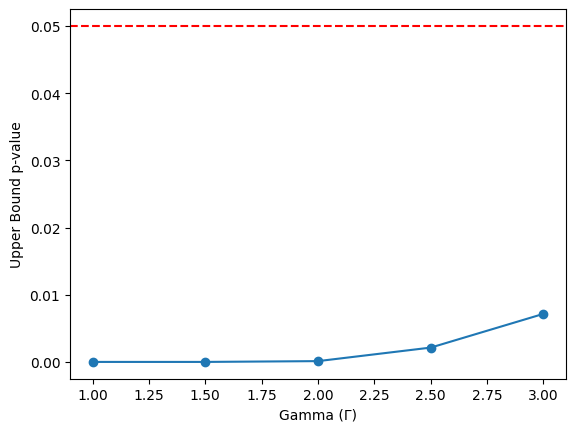

In [11]:
def sensitivity_analysis(contrasts, gamma_values):
    results = {}
    for gamma in gamma_values:
        # Calculate worst-case p-value bounds
        ranks = np.argsort(np.abs(contrasts))[::-1] + 1
        p_plus = 1 / (1 + gamma)
        p_minus = gamma / (1 + gamma)
        
        # Calculate sensitivity bound
        t_plus = sum(ranks * p_plus)
        t_minus = sum(ranks * p_minus)
        
        # Normal approximation
        mu = (t_plus + t_minus)/2
        sigma = np.sqrt(((t_plus - mu)**2 + (t_minus - mu)**2) / 3 + 1e-6)
        z = (sum(ranks) - mu)/sigma
        p_bound = norm.sf(abs(z))
        
        results[gamma] = p_bound
    
    # Plot sensitivity
    plt.plot(results.keys(), results.values(), marker='o')
    plt.axhline(0.05, color='red', linestyle='--')
    plt.xlabel('Gamma (Γ)')
    plt.ylabel('Upper Bound p-value')
    plt.show()
    
    return results

sensitivity = sensitivity_analysis(contrasts, [1.0, 1.5, 2.0, 2.5, 3.0])